In [38]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from deepchem.molnet import load_hiv, load_tox21, load_bace_classification, load_sider, load_clintox, load_bbbp
from hdpy.metrics import compute_roc_enrichment
import seaborn as sns
sns.set_style("whitegrid")


# plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)

from tqdm import tqdm
from pathlib import Path

RANDOM_SEED=5
output_result_dir = Path(f"/p/vast1/jones289/hd_results/{RANDOM_SEED}")

green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
red_color_pal = sns.color_palette("Reds", 10)
purple_color_pal = sns.color_palette("Purples", 10)
rocket_color_pal = sns.color_palette("rocket", 10)

plot_dict = {
    "RPFP": ("HDB-RPFP", red_color_pal[4]),
    "Combo": ("HDB-Combo", purple_color_pal[5]),
            #   "HDBind (10k) (GPU-no encode)": green_color_pal[8],
              "MoLFormer": ("HDB-MoLFormer", green_color_pal[7]),
              # "MoLFormer+RPFP": ("HDB Combo", green_color_pal[9]),
              "MolCLR": ("HDB-MolCLR", green_color_pal[4]),
              "DECFP-4": ("HDB-DECFP", red_color_pal[8]),
              "MLP": ("MLP", "black"),
    }


model_name_map = {
    "hdbind-molformer-decfp-combo-1k": "HDB-Combo",
    "hdbind-molformer-decfp-combo-100k": "HDB-Combo",
    "hdbind-molformer-decfp-combo-1m": "HDB-Combo",
    "hdbind-molformer-decfp-combo": "HDB-Combo",
    "hdbind-rp-ecfp-1024-1-1k": "HDB-RPFP",
    "hdbind-rp-ecfp-1024-1": "HDB-RPFP",
    "hdbind-rp-ecfp-1024-1-100k": "HDB-RPFP",
    "hdbind-rp-ecfp-1024-1-1m": "HDB-RPFP",
    "hdbind-rp-molformer-1k": "HDB-MoLFormer",
    "hdbind-rp-molformer": "HDB-MoLFormer",
    "hdbind-rp-molformer-100k": "HDB-MoLFormer",
    "hdbind-rp-molformer-1m": "HDB-MoLFormer",
    "hdbind-rp-molclr-1k": "HDB-MolCLR",
    "hdbind-rp-molclr": "HDB-MolCLR",
    "hdbind-rp-molclr-100k": "HDB-MolCLR",
    "hdbind-rp-molclr-1m": "HDB-MolCLR",
    "hdbind-directecfp-1k-1": "HDB-DECFP",
    "hdbind-directecfp-1k-2": "HDB-DECFP",
    "hdbind-directecfp-1k-4": "HDB-DECFP",
    "hdbind-directecfp-10k-1": "HDB-DECFP",
    "hdbind-directecfp-10k-2": "HDB-DECFP",
    "hdbind-directecfp-10k-4": "HDB-DECFP",
    "hdbind-directecfp-100k-1": "HDB-DECFP",
    "hdbind-directecfp-100k-2": "HDB-DECFP",
    "hdbind-directecfp-100k-4": "HDB-DECFP",
    "hdbind-directecfp-1m-1": "HDB-DECFP",
    "hdbind-directecfp-1m-2": "HDB-DECFP",
    "hdbind-directecfp-1m-4": "HDB-DECFP",
    "mlp-1024-1": "MLP-1024",
    "mlp-2048-1": "MLP-2048"
}



config_dir = "roc_auc_configs_final"

In [39]:
def collect_roc_metrics(dataset:str, split:str, config_list:list):

    result_dict = {"model": [],
                   "D": [],
                   "target": [],
                   "seed": [],
                   "roc-auc": [],
                   "er-1": []
                   }

    target_list = []
    if dataset in ["bbbp", "tox21", "clintox", "hiv", "bace", "sider"]:
        if dataset == "bbbp":
            data = load_bbbp()
        if dataset == "tox21":
            data = load_tox21()
        if dataset == "clintox":
            data = load_clintox(splitter="scaffold")
        if dataset == "hiv":
            data = load_hiv()
        if dataset == "bace":
            data = load_bace_classification()
        if dataset == "sider":
            data = load_sider()

        target_list = data[0]
    elif dataset == "lit-pcba":
        lit_pcba_ave_p = Path("/p/vast1/jones289/lit_pcba/AVE_unbiased")
        target_list = [x.name for x in list(lit_pcba_ave_p.glob("*/"))]

    # print(target_list)
    for config_path in tqdm(config_list):
        print(config_path)
        exp_name = config_path.stem
        # for d in range(10):
        for target_name in target_list:
            
            result_file = Path(
                f"{output_result_dir}/{exp_name}.{dataset}-{target_name.replace(' ','_')}-{split}.{RANDOM_SEED}.pkl"
            )
            try:
                data = torch.load(result_file)
            except FileNotFoundError as e:
                print(f"{e}. {result_file} does not exist.")

            for random_state in data["trials"].keys():
                result_dict["model"].append(model_name_map[exp_name])
                result_dict["D"].append(data["args"].D)
                result_dict["target"].append(target_name)
                result_dict["seed"].append(random_state)
                result_dict["roc-auc"].append(data["trials"][random_state]["roc-auc"])

                try:
                    
                    er_1 = data["trials"][random_state]["er-1"]
                    result_dict["er-1"].append(er_1)

                except KeyError as e:
            
                    print(f"{e}. result missing roc-enrichment metrics. computing these now.")
                    for trial_idx in data["trials"].keys():
                        scores = None 
                        
                        if "er-1" not in data["trials"][trial_idx].keys():

                            # if config.model in ["molehd-bpe", "selfies","hdbind-directecfp-10k-4",
                                                # "hdbind-molformer-decfp-combo",
                                                #   "ecfp", "rp", "directecfp"]:
                                # scores = model_data_dict["trials"][trial_idx]["eta"]
                            if "mlp" in exp_name.lower():
                                scores = data["trials"][trial_idx]["eta"][:, 1]
                            else:

                                scores = data["trials"][trial_idx]["eta"]
                            
                            labels = data["trials"][trial_idx]['y_true']

                            trial_er_1 = compute_roc_enrichment(scores=scores, labels=labels, fpr_thresh=.01)

                            data["trials"][trial_idx]["er-1"] = trial_er_1
            

 
                    er_1 = data["trials"][random_state]["er-1"]
                    result_dict["er-1"].append(er_1)

    return pd.DataFrame(result_dict)

In [40]:
ave_metric_df = collect_roc_metrics(dataset="lit-pcba", split="ave", config_list=list(Path(f"/usr/WS1/jones289/hd-cuda-master/hdpy/{config_dir}").glob("*.yml")))

  0%|          | 0/22 [00:00<?, ?it/s]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-molformer-100k.yml


  5%|▍         | 1/22 [00:04<01:29,  4.27s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-molformer-1k.yml


  9%|▉         | 2/22 [00:06<01:01,  3.06s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-molformer-1m.yml


 14%|█▎        | 3/22 [00:27<03:35, 11.33s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-molformer.yml


 18%|█▊        | 4/22 [00:30<02:20,  7.80s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-molformer-decfp-combo-100k.yml


 23%|██▎       | 5/22 [00:34<01:49,  6.46s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-molformer-decfp-combo-1m.yml


 27%|██▋       | 6/22 [00:44<02:06,  7.93s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-molformer-decfp-combo-1k.yml
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missi

 32%|███▏      | 7/22 [00:48<01:37,  6.49s/it]

'er-1'. result missing roc-enrichment metrics. computing these now.
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-molformer-decfp-combo.yml


 36%|███▋      | 8/22 [00:50<01:12,  5.16s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-directecfp-1m-4.yml


 41%|████      | 9/22 [01:01<01:31,  7.01s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-directecfp-100k-4.yml


 45%|████▌     | 10/22 [01:05<01:11,  5.94s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-directecfp-10k-4.yml


 50%|█████     | 11/22 [01:07<00:53,  4.86s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-directecfp-1k-4.yml
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-en

 55%|█████▍    | 12/22 [01:11<00:44,  4.46s/it]

'er-1'. result missing roc-enrichment metrics. computing these now.
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-ecfp-1024-1-100k.yml


 59%|█████▉    | 13/22 [01:15<00:40,  4.45s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-ecfp-1024-1.yml


 64%|██████▎   | 14/22 [01:18<00:30,  3.82s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-ecfp-1024-1-1k.yml
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-

 68%|██████▊   | 15/22 [01:21<00:25,  3.66s/it]

'er-1'. result missing roc-enrichment metrics. computing these now.
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-ecfp-1024-1-1m.yml


 73%|███████▎  | 16/22 [01:49<01:05, 10.94s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-molclr-100k.yml


 77%|███████▋  | 17/22 [01:53<00:44,  8.97s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-molclr-1k.yml
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enric

 82%|████████▏ | 18/22 [01:57<00:29,  7.33s/it]

'er-1'. result missing roc-enrichment metrics. computing these now.
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-molclr-1m.yml


 86%|████████▋ | 19/22 [02:17<00:34, 11.38s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-molclr.yml


 91%|█████████ | 20/22 [02:20<00:17,  8.72s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/mlp-2048-1.yml
[Errno 2] No such file or directory: '/p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ADRB2-ave.5.pkl'. /p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ADRB2-ave.5.pkl does not exist.
[Errno 2] No such file or directory: '/p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ALDH1-ave.5.pkl'. /p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ALDH1-ave.5.pkl does not exist.
[Errno 2] No such file or directory: '/p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ESR1_ago-ave.5.pkl'. /p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ESR1_ago-ave.5.pkl does not exist.
[Errno 2] No such file or directory: '/p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ESR1_ant-ave.5.pkl'. /p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ESR1_ant-ave.5.pkl does not exist.
[Errno 2] No such file or directory: '/p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-FEN1-ave.5.pkl'. /p/vast1/jones289/hd_results/5/mlp-2048-1.lit-p

100%|██████████| 22/22 [02:22<00:00,  6.50s/it]


In [41]:
random_metric_df = collect_roc_metrics(dataset="lit-pcba", split="random", config_list=list(Path(f"/usr/WS1/jones289/hd-cuda-master/hdpy/{config_dir}").glob("*.yml")))

  0%|          | 0/22 [00:00<?, ?it/s]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-molformer-100k.yml


  5%|▍         | 1/22 [00:04<01:28,  4.22s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-molformer-1k.yml
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-en

  9%|▉         | 2/22 [00:07<01:16,  3.84s/it]

'er-1'. result missing roc-enrichment metrics. computing these now.
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-molformer-1m.yml


 14%|█▎        | 3/22 [00:27<03:28, 10.95s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-molformer.yml


 18%|█▊        | 4/22 [00:28<02:11,  7.33s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-molformer-decfp-combo-100k.yml


 23%|██▎       | 5/22 [00:31<01:37,  5.74s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-molformer-decfp-combo-1m.yml


 27%|██▋       | 6/22 [00:42<01:56,  7.25s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-molformer-decfp-combo-1k.yml
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missi

 32%|███▏      | 7/22 [00:45<01:28,  5.92s/it]

'er-1'. result missing roc-enrichment metrics. computing these now.
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-molformer-decfp-combo.yml


 36%|███▋      | 8/22 [00:48<01:09,  4.96s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-directecfp-1m-4.yml


 41%|████      | 9/22 [00:58<01:28,  6.77s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-directecfp-100k-4.yml


 45%|████▌     | 10/22 [01:02<01:09,  5.78s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-directecfp-10k-4.yml


 50%|█████     | 11/22 [01:04<00:51,  4.72s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-directecfp-1k-4.yml
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-en

 55%|█████▍    | 12/22 [01:08<00:43,  4.32s/it]

'er-1'. result missing roc-enrichment metrics. computing these now.
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-ecfp-1024-1-100k.yml


 59%|█████▉    | 13/22 [01:12<00:38,  4.33s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-ecfp-1024-1.yml


 64%|██████▎   | 14/22 [01:14<00:29,  3.73s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-ecfp-1024-1-1k.yml
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-

 68%|██████▊   | 15/22 [01:18<00:25,  3.66s/it]

'er-1'. result missing roc-enrichment metrics. computing these now.
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-ecfp-1024-1-1m.yml


 73%|███████▎  | 16/22 [01:39<00:54,  9.05s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-molclr-100k.yml


 77%|███████▋  | 17/22 [01:44<00:38,  7.61s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-molclr-1k.yml
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enrichment metrics. computing these now.
'er-1'. result missing roc-enric

 82%|████████▏ | 18/22 [01:47<00:25,  6.38s/it]

'er-1'. result missing roc-enrichment metrics. computing these now.
/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-molclr-1m.yml


 86%|████████▋ | 19/22 [02:08<00:32, 10.81s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/hdbind-rp-molclr.yml


 91%|█████████ | 20/22 [02:11<00:16,  8.26s/it]

/usr/WS1/jones289/hd-cuda-master/hdpy/roc_auc_configs_final/mlp-2048-1.yml
[Errno 2] No such file or directory: '/p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ADRB2-random.5.pkl'. /p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ADRB2-random.5.pkl does not exist.
[Errno 2] No such file or directory: '/p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ALDH1-random.5.pkl'. /p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ALDH1-random.5.pkl does not exist.
[Errno 2] No such file or directory: '/p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ESR1_ago-random.5.pkl'. /p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ESR1_ago-random.5.pkl does not exist.
[Errno 2] No such file or directory: '/p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ESR1_ant-random.5.pkl'. /p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-ESR1_ant-random.5.pkl does not exist.
[Errno 2] No such file or directory: '/p/vast1/jones289/hd_results/5/mlp-2048-1.lit-pcba-FEN1-random.5.pkl'. /p/vast1/jones289/hd

100%|██████████| 22/22 [02:13<00:00,  6.06s/it]


In [42]:
random_metric_df

,model,D,target,seed,roc-auc,er-1
0,HDB-MoLFormer,100000,ADRB2,0,0.649411,25.000000
1,HDB-MoLFormer,100000,ADRB2,1,0.669319,25.000000
2,HDB-MoLFormer,100000,ADRB2,2,0.678273,25.000000
3,HDB-MoLFormer,100000,ADRB2,3,0.682488,25.000000
4,HDB-MoLFormer,100000,ADRB2,4,0.683325,25.000000
...,...,...,...,...,...,...
3220,MLP-1024,10000,VDR,5,0.833841,36.746988
3221,MLP-1024,10000,VDR,6,0.844265,36.746988
3222,MLP-1024,10000,VDR,7,0.839351,35.542169
3223,MLP-1024,10000,VDR,8,0.840733,37.951807


In [43]:
mlp_1024_mean_rocauc_random = (random_metric_df[random_metric_df["model"].apply(lambda x: x.lower()=="mlp-1024")]).groupby(["model", "D"]).mean()["roc-auc"].values

mlp_1024_mean_rocauc_ave = (ave_metric_df[ave_metric_df["model"].apply(lambda x: x.lower()=="mlp-1024")]).groupby(["model", "D"]).mean()["roc-auc"].values

In [44]:
pd.__version__

'1.4.0'

In [45]:
model_dict = {
    "MoleHD-BPE": rocket_color_pal[4],
    "HDB-RPFP": green_color_pal[0],
    "HDB-DECFP": green_color_pal[3],
    "HDB-MolCLR": green_color_pal[5],
    "HDB-MoLFormer": green_color_pal[7],
    "HDB-Combo": green_color_pal[9],
    "MLP": blue_color_pal[7],
    # "Vina": ("Vina", "salmon"),
}

model_order_dict = {
    "HDB-RPFP": 0,
    "HDB-DECFP": 1,
    "HDB-MolCLR": 2,
    "HDB-MoLFormer": 3,
    "HDB-Combo": 4}



def make_plot(df, ax, metric):
    # print(df.head())
    df = df.sort_values(by='model', key=lambda x: x.map(model_order_dict))

    width=0.8
    gap=0.2

    sns.boxenplot(data=df, 
            x="D", y=metric, 
            hue="model", 
            ax=ax,
            # order=model_order_list,
            palette={x: model_dict[x] for x in model_dict.keys()},
            width=width, 
            gap=gap
            )
    
def make_roc_auc_plot():
    f,ax = plt.subplots(2,1, figsize=(16,20), sharex=True, sharey=True)

    make_plot(df=random_metric_df[random_metric_df["model"].apply(lambda x: "mlp" not in x.lower())],
          ax=ax[0], metric="roc-auc")

    make_plot(df=ave_metric_df[ave_metric_df["model"].apply(lambda x: "mlp" not in x.lower())],
          ax=ax[1], metric="roc-auc")
    ax[0].set_ylabel("ROC-AUC")
    ax[1].set_ylabel("")

    ax[0].set_title("Random", fontsize=18)
    ax[1].set_title("AVE", fontsize=18)

    alpha=0.7
    handles, labels = ax[0].get_legend_handles_labels()
    handles.append(ax[0].axhline(mlp_1024_mean_rocauc_random, color="red", linestyle="--", alpha=alpha))
    labels.append("MLP ($\mu$)")
    # ax[0].legend(handles,labels, fontsize="x-large", loc="best")
    ax[0].get_legend().remove()

    handles, labels = ax[1].get_legend_handles_labels()
    handles.append(ax[1].axhline(mlp_1024_mean_rocauc_ave, color="red", linestyle="--", alpha=alpha))
    labels.append("MLP ($\mu$)")
    ax[1].legend(handles,labels, fontsize="x-large", loc="best")
    ax[0].set_xlabel("HDC Dimension $D$", fontsize=20)
    ax[1].set_xlabel("HDC Dimension $D$", fontsize=20)

    plt.tight_layout()
    plt.savefig("lit-pcba-rocauc-boxenplot.png", dpi=450)
    
def make_er1_plot():
    f,ax = plt.subplots(1,1, figsize=(16,8), sharex=True, sharey=True)


    make_plot(df=ave_metric_df[ave_metric_df["model"].apply(lambda x: "mlp" not in x.lower())],
          ax=ax, metric="er-1")
    ax.set_ylabel("")

    ax.set_title("AVE", fontsize=18)

    alpha=0.7
    handles, labels = ax.get_legend_handles_labels()
    handles.append(ax.axhline(4.78, color="red", linestyle="--", alpha=alpha))
    labels.append("GRIM ($\mu$)")
    handles.append(ax.axhline(3.46, color="darkred", linestyle="-.", alpha=alpha))
    labels.append("Pafnucy ($\mu$)")

    ax.legend(handles,labels, fontsize="x-large", loc="best")
    ax.set_xlabel("HDC Dimension $D$", fontsize=20)

    plt.tight_layout()
    plt.savefig("lit-pcba-er1-boxenplot.png", dpi=450)

In [46]:
# make_roc_auc_plot()

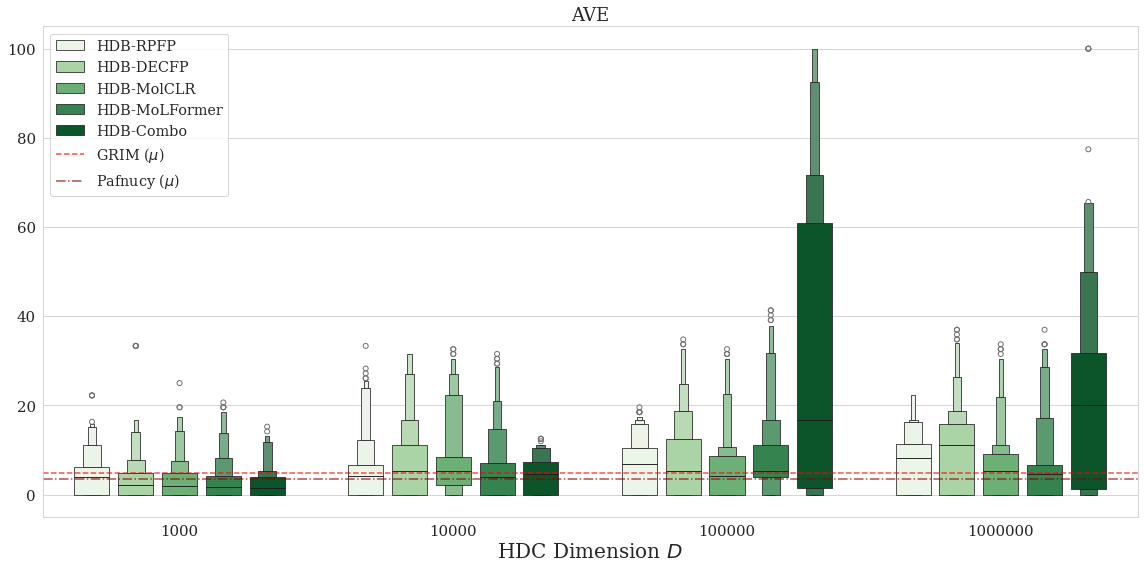

In [47]:
make_er1_plot()

In [48]:
# for grp, grp_df in ave_metric_df.groupby(["model", 'D']):
    # print(grp, grp_df)

In [83]:
ave_metric_df['target'].unique()

array(['ADRB2', 'ALDH1', 'ESR1_ago', 'ESR1_ant', 'FEN1', 'GBA', 'IDH1',
       'KAT2A', 'MAPK1', 'MTORC1', 'OPRK1', 'PKM2', 'PPARG', 'TP53',
       'VDR'], dtype=object)

In [97]:
lit_pcba_summary_df = pd.read_csv("/g/g13/jones289/workspace/hd-cuda-master/notebooks/lit-pcba-dataset-overview.csv")
merge_df = pd.merge(ave_metric_df, lit_pcba_summary_df, left_on="target", right_on="Set")


# merge_df
# paper_df = merge_df[merge_df["D"] > 10000].groupby(["model", 'D', 'target']).describe()[['roc-auc', 'er-1']].round(2)
paper_df = merge_df[merge_df["D"] > 10000].groupby(["model", 'D', 'target']).describe().round(2)


mask_cols = [x for x in paper_df.columns if x[1] in ["mean", "std", "min", "max"]]
paper_df = paper_df.loc[:, mask_cols]
mask_cols = [x for x in paper_df.columns if x[0] in ["roc-auc", "er-1", "Actives"]]
paper_df = paper_df.loc[:, mask_cols]
# print(paper_df.columns)
mask_cols = [x for x in paper_df.columns if x[0] != "Actives" or x[0] == "Actives" and x[1] not in ["std", "min", "max"]]
paper_df = paper_df.loc[:, mask_cols]
# paper_df.to_csv("lit-pcba-by-target-metrics.csv")
paper_df.to_latex("lit-pcba-by-target-metrics.tex")
paper_df

/var/tmp/jones289/ipykernel_237365/582430755.py:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  paper_df.to_latex("lit-pcba-by-target-metrics.tex")


roc-auc                      er-1                \
                            mean   std   min   max    mean   std     min   
model     D       target                                                   
HDB-Combo 100000  ADRB2     1.00  0.00  1.00  1.00  100.00  0.00  100.00   
                  ALDH1     0.53  0.01  0.51  0.55    1.53  0.30    1.14   
                  FEN1      0.97  0.00  0.96  0.97   73.55  3.12   65.88   
                  GBA       0.73  0.02  0.68  0.74   35.09  5.37   24.39   
                  IDH1      0.44  0.05  0.36  0.52    0.75  2.37    0.00   
...                          ...   ...   ...   ...     ...   ...     ...   
HDB-RPFP  1000000 OPRK1     0.70  0.01  0.69  0.71    1.67  5.27    0.00   
                  PKM2      0.74  0.01  0.71  0.75    9.12  1.05    7.35   
                  PPARG     0.80  0.02  0.76  0.83   11.67  8.05    0.00   
                  TP53      0.72  0.02  0.68  0.74   14.74  2.22   10.53   
                  VDR       0.76  0.01  0.75  0.77   10.36  1.05    9.09   

                                 Actives  
                             max    mean  
model     D       target                  
HDB-Combo 100000  ADRB2   100.00    17.0  
                  ALDH1     2.11  5363.0  
                  FEN1     76.09   360.0  
                  GBA      39.02   163.0  
                  IDH1      7.50    39.0  
...                          ...     ...  
HDB-RPFP  1000000 OPRK1    16.67    24.0  
                  PKM2     10.29   546.0  
                  PPARG    16.67    24.0  
                  TP53     15.79    64.0  
                  VDR      12.12   655.0  

[130 rows x 9 columns]